# 020 - Sklearn DuckDB SQL Regression (Sklearn Visualizations)

This notebook mirrors the **DuckDB SQL preprocessing** used in the SvelteKit Batch ML regression flow,
but excludes YellowBrick so we can focus on native sklearn visualization APIs.

In [1]:
import duckdb
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
MINIO_HOST = "localhost"
MINIO_PORT = "9000"
MINIO_ENDPOINT = f"{MINIO_HOST}:{MINIO_PORT}"
MINIO_ACCESS_KEY = "minioadmin"
MINIO_SECRET_KEY = "minioadmin123"
PROJECT_NAME = "Estimated Time of Arrival"

In [3]:
DELTA_PATHS = {
    "Transaction Fraud Detection": "s3://lakehouse/delta/transaction_fraud_detection",
    "Estimated Time of Arrival": "s3://lakehouse/delta/estimated_time_of_arrival",
    "E-Commerce Customer Interactions": "s3://lakehouse/delta/e_commerce_customer_interactions",
}

delta_path = DELTA_PATHS.get(PROJECT_NAME)

In [4]:
# Disable AWS EC2 metadata service lookup (prevents 169.254.169.254 errors)
os.environ["AWS_EC2_METADATA_DISABLED"] = "true"

# Create connection (in-memory database)
conn = duckdb.connect()

# Install and load required extensions
conn.execute("INSTALL delta; LOAD delta;")
conn.execute("INSTALL httpfs; LOAD httpfs;")

# Create a secret for S3/MinIO credentials
conn.execute(f"""
    CREATE SECRET minio_secret (
        TYPE S3,
        KEY_ID '{MINIO_ACCESS_KEY}',
        SECRET '{MINIO_SECRET_KEY}',
        REGION 'us-east-1',
        ENDPOINT '{MINIO_ENDPOINT}',
        URL_STYLE 'path',
        USE_SSL false
    );
""")
print("DuckDB extensions loaded and S3 secret configured")

DuckDB extensions loaded and S3 secret configured


## Feature Definitions

Define ETA features for DuckDB SQL preprocessing.

In [5]:
# Feature definitions for Estimated Time of Arrival
ETA_NUMERICAL_FEATURES = [
    "estimated_distance_km",
    "temperature_celsius",
    "driver_rating",
    "hour_of_day",
    "initial_estimated_travel_time_seconds",
    "debug_traffic_factor",
    "debug_weather_factor",
    "debug_incident_delay_seconds",
    "debug_driver_factor",
]

ETA_CATEGORICAL_FEATURES = [
    "trip_id",
    "driver_id",
    "vehicle_id",
    "origin",
    "destination",
    "weather",
    "day_of_week",
    "vehicle_type",
    "year",
    "month",
    "day",
    "hour",
    "minute",
    "second",
]

ETA_ALL_FEATURES = ETA_NUMERICAL_FEATURES + ETA_CATEGORICAL_FEATURES
ETA_CAT_FEATURE_INDICES = list(range(
    len(ETA_NUMERICAL_FEATURES),
    len(ETA_ALL_FEATURES)
))

print(f"Numerical features: {len(ETA_NUMERICAL_FEATURES)}")
print(f"Categorical features: {len(ETA_CATEGORICAL_FEATURES)}")
print(f"Categorical indices: {ETA_CAT_FEATURE_INDICES}")

Numerical features: 9
Categorical features: 14
Categorical indices: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


## DuckDB SQL Preprocessing

All categorical features are label-encoded in SQL using `DENSE_RANK() - 1`.

In [6]:
def load_data_duckdb_sql(
    delta_path: str,
    sample_frac: float | None = None,
    max_rows: int | None = None,
) -> pd.DataFrame:
    """
    Load and preprocess ETA data using pure DuckDB SQL.

    All categorical features are label-encoded using DENSE_RANK() - 1.
    This produces numeric data compatible with sklearn visualization APIs.

    Args:
        delta_path: Path to Delta Lake table
        sample_frac: Optional fraction of data to sample (0.0-1.0)
        max_rows: Optional maximum number of rows to load

    Returns:
        DataFrame with preprocessed features (all numeric) and target
    """
    query = f"""
    SELECT
        -- Numerical features (unchanged)
        estimated_distance_km,
        temperature_celsius,
        driver_rating,
        hour_of_day,
        initial_estimated_travel_time_seconds,
        debug_traffic_factor,
        debug_weather_factor,
        debug_incident_delay_seconds,
        debug_driver_factor,

        -- Categorical features: Label encoded with DENSE_RANK() - 1
        DENSE_RANK() OVER (ORDER BY trip_id) - 1 AS trip_id,
        DENSE_RANK() OVER (ORDER BY driver_id) - 1 AS driver_id,
        DENSE_RANK() OVER (ORDER BY vehicle_id) - 1 AS vehicle_id,
        DENSE_RANK() OVER (ORDER BY origin) - 1 AS origin,
        DENSE_RANK() OVER (ORDER BY destination) - 1 AS destination,
        DENSE_RANK() OVER (ORDER BY weather) - 1 AS weather,
        DENSE_RANK() OVER (ORDER BY day_of_week) - 1 AS day_of_week,
        DENSE_RANK() OVER (ORDER BY vehicle_type) - 1 AS vehicle_type,

        -- Timestamp components (already integers)
        CAST(date_part('year', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS year,
        CAST(date_part('month', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS month,
        CAST(date_part('day', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS day,
        CAST(date_part('hour', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS hour,
        CAST(date_part('minute', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS minute,
        CAST(date_part('second', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS second,

        -- Target
        simulated_actual_travel_time_seconds

    FROM delta_scan('{delta_path}')
    """

    print(f"Loading ETA data with DuckDB SQL (all features numeric)...")

    if sample_frac is not None and 0 < sample_frac < 1:
        query += f" USING SAMPLE {sample_frac * 100}%"
        print(f"  Sampling: {sample_frac * 100}%")

    if max_rows is not None:
        query += f" LIMIT {max_rows}"
        print(f"  Max rows: {max_rows}")

    df = conn.execute(query).df()
    print(f"  Loaded {len(df):,} rows with {len(df.columns)} columns")
    print(f"  All features numeric: {df.select_dtypes(include=['number']).shape[1]}/{len(df.columns)} columns")

    return df

In [7]:
df = load_data_duckdb_sql(delta_path, max_rows=10000)

Loading ETA data with DuckDB SQL (all features numeric)...
  Max rows: 10000


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 10,000 rows with 24 columns
  All features numeric: 24/24 columns


In [8]:
def process_batch_data_duckdb(
    df: pd.DataFrame,
    test_size: float = 0.2,
    random_state: int = 42,
):
    """
    Process batch data for model training.

    Data is already all-numeric from load_data_duckdb_sql().

    Args:
        df: DataFrame from load_data_duckdb_sql() (all numeric)
        test_size: Fraction for test set
        random_state: Random seed

    Returns:
        X_train, X_test, y_train, y_test
    """
    y = df["simulated_actual_travel_time_seconds"]
    X = df.drop("simulated_actual_travel_time_seconds", axis=1)

    print(f"Features: {len(X.columns)} total ({len(ETA_NUMERICAL_FEATURES)} numeric, {len(ETA_CATEGORICAL_FEATURES)} label-encoded)")
    print("All features are numeric - compatible with sklearn tools")

    print(f"Splitting data: {1-test_size:.0%} train, {test_size:.0%} test...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
    )

    print(f"  Training set: {len(X_train):,} samples")
    print(f"  Test set: {len(X_test):,} samples")
    print(f"  Target mean (train): {y_train.mean():.1f} seconds ({y_train.mean()/60:.1f} minutes)")
    print(f"  Target std (train): {y_train.std():.1f} seconds")

    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = process_batch_data_duckdb(df)

Features: 23 total (9 numeric, 14 label-encoded)
All features are numeric - compatible with sklearn tools
Splitting data: 80% train, 20% test...
  Training set: 8,000 samples
  Test set: 2,000 samples
  Target mean (train): 4771.0 seconds (79.5 minutes)
  Target std (train): 2613.5 seconds


## Sklearn Visualization API (Regression)

This section mirrors the YellowBrick visualizer configuration pattern from notebook 017,
but uses sklearn Display classes and tuned kwargs for regression.

In [10]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import KFold
from sklearn.model_selection import LearningCurveDisplay, ValidationCurveDisplay

In [11]:
feature_names = list(X_train.columns)
categorical_features = [
    feature_names.index(name)
    for name in ETA_CATEGORICAL_FEATURES
    if name in feature_names
]

base_estimator = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)
base_estimator.fit(X_train, y_train)
print('Base estimator fitted for sklearn displays.')

Base estimator fitted for sklearn displays.


In [12]:
SKLEARN_VIZ_PATH = 'models/estimated_time_of_arrival/sklearn_visualizations'
os.makedirs(SKLEARN_VIZ_PATH, exist_ok=True)

def save_display(display, filename: str, show: bool = True) -> str:
    output_path = os.path.join(SKLEARN_VIZ_PATH, filename)
    if show:
        plt.show()
    display.figure_.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close(display.figure_)
    return output_path

In [13]:
def sklearn_regression_viz_kwargs():
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    return {
        'prediction_error': {
            'kind': 'residual_vs_predicted',
            'subsample': 2000,
            'random_state': 42,
            'scatter_kwargs': {
                'alpha': 0.6,
                's': 12,
                'edgecolor': 'k',
            },
            'line_kwargs': {
                'color': '#2c7fb8',
                'linewidth': 2,
            },
        },
        'partial_dependence': {
            'features': [
                'estimated_distance_km',
                'temperature_celsius',
                'driver_rating',
                'weather',
            ],
            'categorical_features': categorical_features,
            'feature_names': feature_names,
            'grid_resolution': 50,
            'percentiles': (0.05, 0.95),
            'n_cols': 2,
            'subsample': 2000,
            'random_state': 42,
            'kind': 'average',
            'line_kw': {
                'linewidth': 2,
                'color': '#1f77b4',
            },
        },
        'learning_curve': {
            'train_sizes': np.linspace(0.1, 1.0, 5),
            'cv': cv,
            'scoring': 'neg_root_mean_squared_error',
            'shuffle': True,
            'random_state': 42,
            'score_type': 'both',
            'std_display_style': 'fill_between',
            'line_kw': {
                'linewidth': 2,
            },
            'fill_between_kw': {
                'alpha': 0.2,
            },
        },
        'validation_curve': {
            'param_name': 'max_depth',
            'param_range': [4, 8, 12, 16, 20],
            'cv': cv,
            'scoring': 'neg_root_mean_squared_error',
            'score_type': 'both',
            'std_display_style': 'fill_between',
            'line_kw': {
                'linewidth': 2,
            },
            'fill_between_kw': {
                'alpha': 0.2,
            },
        },
    }

In [14]:
def sklearn_regression_visualizers(viz_config: dict):
    results = {}
    errors = []
    total = 0

    def run_display(name, builder):
        nonlocal total
        total += 1
        try:
            display = builder()
            results[name] = save_display(display, f'{name}.png', show=True)
            print(f'  OK: {name} saved')
        except Exception as exc:
            errors.append((name, str(exc)))
            print(f'  FAILED: {name} failed: {exc}')

    print('')
    print('=== Sklearn Regression Visualization Run ===')

    run_display(
        'PredictionErrorDisplay',
        lambda: PredictionErrorDisplay.from_estimator(
            base_estimator, X_test, y_test, **viz_config['prediction_error']
        ),
    )
    run_display(
        'PartialDependenceDisplay',
        lambda: PartialDependenceDisplay.from_estimator(
            base_estimator, X_train, **viz_config['partial_dependence']
        ),
    )
    run_display(
        'LearningCurveDisplay',
        lambda: LearningCurveDisplay.from_estimator(
            base_estimator, X_train, y_train, **viz_config['learning_curve']
        ),
    )
    run_display(
        'ValidationCurveDisplay',
        lambda: ValidationCurveDisplay.from_estimator(
            base_estimator, X_train, y_train, **viz_config['validation_curve']
        ),
    )

    print('')
    print(f'Saved {len(results)} of {total} sklearn visualizations.')
    if errors:
        print('Failures:')
        for name, error in errors:
            print(f'  {name}: {error}')
    return results


=== Sklearn Regression Visualization Run ===


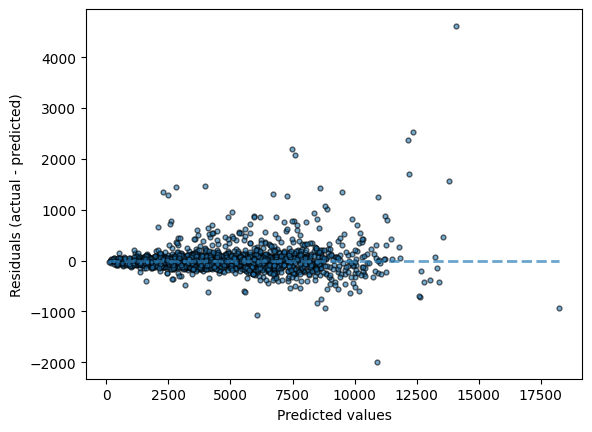

  OK: PredictionErrorDisplay saved


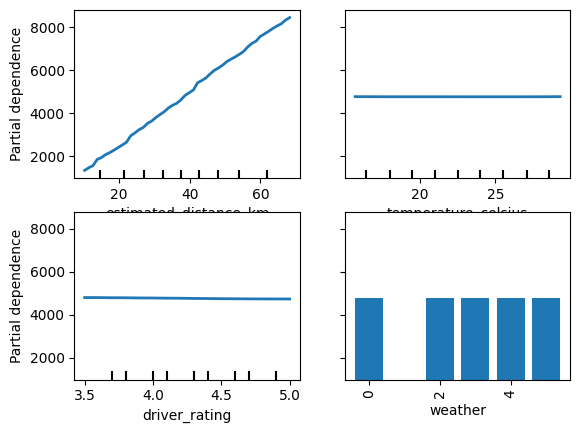

  OK: PartialDependenceDisplay saved


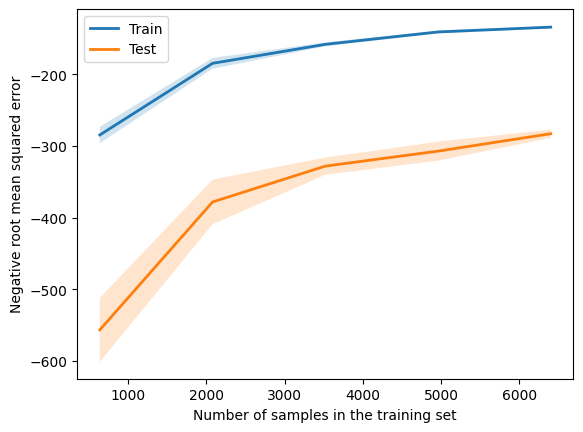

  OK: LearningCurveDisplay saved


KeyboardInterrupt: 

In [15]:
viz_config = sklearn_regression_viz_kwargs()
results = sklearn_regression_visualizers(viz_config)